In [ ]:
!pip install transformers accelerate sentencepiece -q
!pip install konlpy -q
!apt-get install -y fonts-nanum > /dev/null

In [ ]:
import pandas as pd

claude_df = pd.read_csv("claude_summarized.csv", encoding="utf-8")
copilot_df = pd.read_csv("copilot_summarized.csv", encoding="cp949")
gpt4_df = pd.read_csv("GPT4_summarized.csv", encoding="cp949")
gemini_df = pd.read_csv("gemini_summarized.csv", encoding="cp949")

claude_df["source"] = "claude"
copilot_df["source"] = "copilot"
gpt4_df["source"] = "gpt4"
gemini_df["source"] = "gemini"

df_all = pd.concat([claude_df, copilot_df, gpt4_df, gemini_df], ignore_index=True)

print("총 샘플 수:", len(df_all))
print("레이블 분포:\n", df_all["source"].value_counts())
df_all.head()

총 샘플 수: 2000
레이블 분포:
 source
claude     500
copilot    500
gpt4       500
gemini     500
Name: count, dtype: int64


,prompt_id,prompt_text,model_label,response,source,model
0,1,부산시(시장 박형준)는 지난 2020년 12월 말부터 입주를 시작한 해운대구 좌동 ...,claude-3-5-sonnet,부산시가 해운대구 좌동에 조성한 창업지원주택 내 '창업공간100' 개소식이 4월 2...,claude,NaN
1,2,"김포 문수산성의 유실구간에서 아문과 수문, 성벽기초가 발견돼 문수산성의 상당부분의 ...",claude-3-5-sonnet,김포시가 사적 제139호 김포 문수산성의 서측 성벽 유실구간에 대한 발굴조사를 완료...,claude,NaN
2,3,산림을 관리하고 보호해야 할 남부지방산림청 산하 영덕국유림관리소가 산림 벌채 운영 ...,claude-3-5-sonnet,남부지방산림청 산하 영덕국유림관리소가 2019년 12월 영양군 수비면 오기리 일대 ...,claude,NaN
3,4,오는 23일(화) 방송되는 티캐스트 E채널 ‘노는언니’에는 대한민국 여자 야구의 모...,claude-3-5-sonnet,E채널 '노는언니' 23일 방송에는 한국 여자 야구의 선구자 김라경 선수가 출연한다...,claude,NaN
4,5,경북 제1의 도시 포항시가 인구감소 위기에 직면했다. 지난 5년간 매년 2000~3...,claude-3-5-sonnet,포항시가 심각한 인구감소 위기에 직면해있습니다. 2016년 52만2000명이었던 인...,claude,NaN


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_all["response"].astype(str)
y = df_all["source"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_map = dict(zip(le.classes_, le.transform(le.classes_)))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset
import torch

MODEL_NAME = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 256

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts.tolist()
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)


In [ ]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
import torch

# 모델 준비
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)
model.to(device)

# 하이퍼파라미터
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
PATIENCE = 3
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# EarlyStopping 변수
best_val_acc = 0
patience_counter = 0


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Train Loss: {total_loss:.4f}")

    # 검증
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Validation Accuracy: {val_acc:.4f}")

    # EarlyStopping 조건 확인
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(" Best model saved.")
    else:
        patience_counter += 1
        print(f"⏳ Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print(" Early stopping triggered.")
            break

[Epoch 1] Training: 100%|██████████| 88/88 [01:02<00:00,  1.40it/s]


Train Loss: 97.4288
Validation Accuracy: 0.5967
 Best model saved.


[Epoch 2] Training: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]


Train Loss: 64.7133
Validation Accuracy: 0.6333
 Best model saved.


[Epoch 3] Training: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]


Train Loss: 41.8240
Validation Accuracy: 0.7267
 Best model saved.


[Epoch 4] Training: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s]


Train Loss: 27.0800
Validation Accuracy: 0.8067
 Best model saved.


[Epoch 5] Training: 100%|██████████| 88/88 [01:02<00:00,  1.42it/s]


Train Loss: 18.8939
Validation Accuracy: 0.8000
⏳ Patience: 1/3


[Epoch 6] Training: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]


Train Loss: 12.9560
Validation Accuracy: 0.7867
⏳ Patience: 2/3


[Epoch 7] Training: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]


Train Loss: 7.5521
Validation Accuracy: 0.8167
 Best model saved.


[Epoch 8] Training: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s]


Train Loss: 3.9880
Validation Accuracy: 0.7867
⏳ Patience: 1/3


[Epoch 9] Training: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train Loss: 5.2355
Validation Accuracy: 0.7933
⏳ Patience: 2/3


[Epoch 10] Training: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


Train Loss: 7.3744
Validation Accuracy: 0.7200
⏳ Patience: 3/3
 Early stopping triggered.


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=8)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

print(f"테스트셋 정확도: {correct / total:.4f}")


테스트셋 정확도: 0.8400


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

target_names = list(label_map.keys())

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

report_df = pd.DataFrame(classification_report(
    true_labels, predicted_labels, target_names=target_names, output_dict=True
)).transpose()

print("\n📋 Precision / Recall / F1-score (요약):")
print(report_df[['precision', 'recall', 'f1-score']])


Classification Report:
              precision    recall  f1-score   support

      claude       0.78      0.92      0.85        75
     copilot       0.79      0.85      0.82        75
      gemini       0.94      0.81      0.87        75
        gpt4       0.88      0.77      0.82        75

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300


📋 Precision / Recall / F1-score (요약):
              precision    recall  f1-score
claude         0.784091  0.920000  0.846626
copilot        0.790123  0.853333  0.820513
gemini         0.938462  0.813333  0.871429
gpt4           0.878788  0.773333  0.822695
accuracy       0.840000  0.840000  0.840000
macro avg      0.847866  0.840000  0.840316
weighted avg   0.847866  0.840000  0.840316


<Figure size 600x600 with 0 Axes>

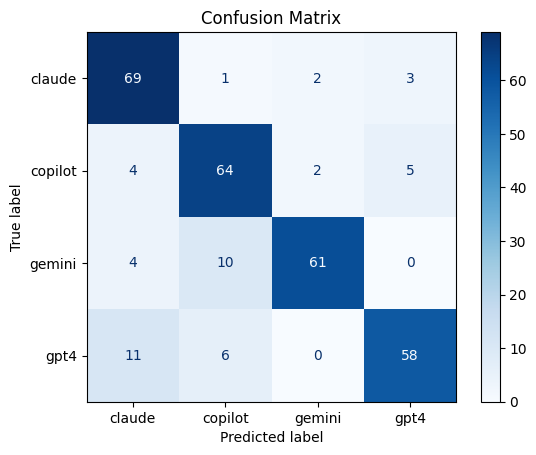

In [ ]:
# 혼동 행렬

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# 라벨 이름 복원
idx_to_label = {v: k for k, v in label_map.items()}

# 예측 결과 보기용 리스트
predicted_labels = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 일부 샘플 출력
for i in range(10):
    print(f"[{i+1}] 실제: {idx_to_label[true_labels[i]]} / 예측: {idx_to_label[predicted_labels[i]]}")


[1] 실제: gpt4 / 예측: claude
[2] 실제: gemini / 예측: gemini
[3] 실제: copilot / 예측: copilot
[4] 실제: copilot / 예측: copilot
[5] 실제: copilot / 예측: copilot
[6] 실제: gemini / 예측: gemini
[7] 실제: gemini / 예측: gemini
[8] 실제: gpt4 / 예측: gpt4
[9] 실제: gpt4 / 예측: claude
[10] 실제: gpt4 / 예측: gpt4


In [ ]:
import pandas as pd

X_test_list = X_test.tolist()

true_label_names = [idx_to_label[label] for label in true_labels]
pred_label_names = [idx_to_label[label] for label in predicted_labels]

test_result_df = pd.DataFrame({
    "text": X_test_list,
    "true_label": true_label_names,
    "predicted_label": pred_label_names
})

# 저장
test_result_df.to_csv("test_predictions.csv", index=False, encoding="utf-8-sig")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 예: 내 드라이브에 "model_checkpoints" 폴더에 저장
!mkdir -p /content/drive/MyDrive/model_checkpoints
!cp best_model.pt /content/drive/MyDrive/model_checkpoints/best_model.pt


In [ ]:
# 모델과 토크나이저 저장
model.save_pretrained("./KLUE_model")
tokenizer.save_pretrained("./KLUE_model")
print("모델 저장 완료: ./KLUE_model 폴더에 저장됨")

모델 저장 완료: ./KLUE_model 폴더에 저장됨


In [ ]:
!mkdir -p /content/drive/MyDrive/model_checkpoints
!cp best_model.pt /content/drive/MyDrive/model_checkpoints/best_model.pt

In [ ]:
idx_to_label = {v: k for k, v in label_map.items()}

def predict_text_class(text):
    model.eval()
    encoding = tokenizer(
        text,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        pred = torch.argmax(output.logits, dim=1).item()

    return idx_to_label[pred]


In [ ]:
# 사용자 입력 예시
my_text = """대한항공이 IATA(국제항공운송협회)와 '트래블 패스' 시범 운영을 위한 업무협약을 체결했다. 트래블 패스는 코로나19 검사 결과를 휴대전화 앱으로 확인할 수 있는 디지털 증명서로, 향후 백신 접종 증명 정보도 포함될 예정이다. 이는 각국의 입국 절차에서 요구되는 코로나19 관련 정보를 효율적으로 공유하기 위해 추진되는 정책이다.

대한항공은 4월 중순 내부 시범 운영을 거친 후, 5월부터 인천-로스앤젤레스(KE011편) 노선에서 승객 대상 시범 서비스를 실시한다. 승객들은 공항 도착 후 코로나19 항원 검사를 받고, 1시간 내 결과를 앱으로 전송받아 탑승할 수 있다. 대한항공은 이를 통해 안전한 항공여행 환경 조성에 기여한다는 방침이다."""

# 예측 결과 출력
print("예측 결과:", predict_text_class(my_text))


예측 결과: claude


In [ ]:
!pip install streamlit -q

In [ ]:
%%writefile app.py

import streamlit as st
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 모델 불러오기
MODEL_PATH = "./KLUE_model"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 라벨 매핑 정의
label_map = {0: "claude", 1: "copilot", 2: "gemini", 3: "gpt4"}
idx_to_label = label_map

# 예측 함수
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return idx_to_label[pred]

# Streamlit 인터페이스
st.title("🧠 한국어 AI 텍스트 생성모델 분류기")
st.markdown("이 앱은 입력된 텍스트가 Claude / Copilot / GPT-4 / Gemini 중 어떤 모델이 생성했는지를 예측합니다.")

user_input = st.text_area("✍️ 텍스트를 입력하세요:", height=200)

if st.button("예측하기"):
    if user_input.strip() == "":
        st.warning("텍스트를 입력해주세요.")
    else:
        prediction = predict(user_input)
        st.success(f"✅ 예측된 생성 모델: **{prediction.upper()}**")


Overwriting app.py


In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# "Password/Enpoint IP for localtunnel is:" 우측에 xx.xxx.xx.xxx 혹은 xx.xxx.xxx.xxx 형식의 숫자가 나온다.

Password/Enpoint IP for localtunnel is: 34.168.213.242


In [ ]:
!npm install localtunnel
# 5
!streamlit run app.py &>/content/logs.txt &
# 6
!npx localtunnel --port 8501

# "your url is:" 우측에 사이트 주소가 생성된다.

⠙⠹⠸⠼⠴
up to date, audited 23 packages in 653ms
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠴⠙your url is: https://cute-bottles-knock.loca.lt
^C
